<a href="https://colab.research.google.com/github/mloyorev/Theory/blob/main/JobSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use this imports:
*   **Numpy:** Python library used to work with matrices and multidimensional arrays, providing functions and tools to perform  operations.
* **Betabinom:** the betabinom function is exported from the scipy.stats module of the SciPy library, a library used to perform mathematical and statistical operations.
*   **Namedtuple:** Data type used to create a immutable class to store a set of values ​​with names associated with them.
*   **Matplotlib.pyplot:** Widely used tool in Python for creating visualizations and charts.
******

In [1]:
import numpy as np
from scipy.stats import betabinom
from collections import namedtuple
import matplotlib.pyplot as plt


For simplicity we will make the following function, which implements a successive approximation method to solve any iterative problem, but first we will design a function for the convergence criterion that we have used in all the exercises, that is, the supremum norm:

In [2]:
# We define the supremum norm as a separte function
def supremum_norm(x, x_new):
  return np.max(np.abs(x_new - x))

In [3]:
def successive_approx(T,                     # Operator
                      x_0,                   # Initial condition
                      M,                     # Convergence criterion
                      tolerance  = 1e-6,     # Error tolerance
                      max_iter   = 10_000,   # Max iteration bound
                      print_step = 25,       # In how many iterations a message is printed
                      verbose    = False):   # Message printing mode

    x     = x_0             # Initial condition
    error = tolerance + 1   # Initilize error
    k     = 1               # Initialize number of iterations

    while error > tolerance and k <= max_iter:                    # The algorithm keeps iterating while error > tolerance and k <= max_iter
        x_new = T(x)                                              # Apply the transoformation
        error = M(x,x_new)                                        # Updates the error with supremum_norm
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        x = x_new
        k += 1

    if error > tolerance:                                         # If error > tolerance, then iteration hit the upper bound
        print(f"Warning: Iteration hit upper bound {max_iter}.")

    elif verbose:
        print(f"Terminated successfully in {k} iterations.")      # If verbose, then the algorithm terminates succesfully

    return x

An example to understand how does **succesive aproximation function** works is to suppose a linear operator...

$$f(x)=ax+b$$

with $\lvert a \rvert<1$.

In this case, the analitical solution by succesive aproximation for $x=ax+b$ is...

$$x^*=lim_{n → ∞}(a^{n}x+b(1+a+...+a^{n}))=\frac{b}{1-a}$$

In [4]:
# Define the function g(x) = 0.3 * x + 100
def g(x):
  return 0.3 * x + 100

In [5]:
# Solving analitically x = 0.3 * x + 100 we have that
s_analitical = 100 / (1 - 0.3)
print(s_analitical)

142.85714285714286


In [6]:
# Using succesive approximation for solving x = 0.3 * x + 100 we have that
s_sapprox = successive_approx(g, 100, supremum_norm)
print(s_sapprox)

142.8571426726569


# **Job Search Model**
In this model the **optimal behavior of an unemployed worker** will be analyzed.

We will assume that the agent begins unemployed in period t=0. He receive a new job offer that will pay him $w_t$ in each period $t$.

The worker can carry out **two actions:**
1. Accept the job offer.
2. Reject job offer.

The objective of the agent is to **maximize the Expected Present Value (EPV) of earnings**. There are two ways to calculate it depending on the decision he make:
1. Accept the current job offer that pays $w$.

$$
\text{EPV} = \text{Stopping Value}= W(w)= w+\beta w+\beta^2 w+...= w/(1-\beta)
$$


2. Continue unemployed, receive the unemployment insurance $c$ and receive the value of the future decisions.

$$
\text{EPV}= \text{Continuation Value}= U = c+ \beta \sum_{w'\in W} \max\{W(w'),u\} \phi (w')
$$

Hence the unemployed worker will choose the maximum between those two options, so we have to

$$
v(w)= \max\{W(w),U\}
$$

or

$$
v(w)= \max\left\{w/(1-\beta),c+ \beta \sum_{w'\in W} max\{W(w'),u\} \phi (w')\right\}
$$

Given that $v(w)= max\{W(w),U\}$, the agent's value function can be expressed as follows, obtaining the Bellman equation for this model

$$
v(w)= \max\left\{\frac{w}{1-\beta},c+ \beta \sum_{w'\in W} v(w') \phi (w')\right\}
$$



and with the Bellman operator

$$
    (Tv)(w) = \max
    \left\{
        \frac{w}{1-\beta},
        c + \beta \sum_{w'} v(w') \phi(w')
    \right\}
$$


## Model Set Up

The **job search model parameters** are:
  

*  w_vals: Possible wage values.

*  $\phi$: PMF of the salary grid.

*  $\beta$: Discount factor.

*  $c$: Unemployment compensation.
  

We introduce a `namedtuple` that stores the data for solving the problem:

In [7]:
Model = namedtuple("Model", ("w_vals", "phi", "beta", "c"))

The next function generates an instance of the named tuple with default values.

In [8]:
def create_job_search_model(
        n     = 50,    # Wage grid number of steps
        w_min = 10.0,  # Lowest wage
        w_max = 60.0,  # Highest wage
        a     = 200,   # Wage distribution parameter
        b     = 100,   # Wage distribution parameter
        beta  = 0.96,  # Discount factor
        c     = 10.0   # Unemployment compensation
    ):
    w_vals = np.linspace(w_min, w_max, n+1)                              # Since n are the number of steps, n+1 is the number of elements in the wealth grid.
    phi    = np.array([betabinom(n+1, a, b).pmf(k) for k in range(n+1)]) # Construction of the PMF of wages in the grid.

    return Model(w_vals = w_vals, phi = phi, beta = beta, c = c)

Here's an instance:

In [9]:
params = create_job_search_model()

As an **exercise**, let's plot the **default wage offer distribution**. In other words, let's plot the wage PMF.

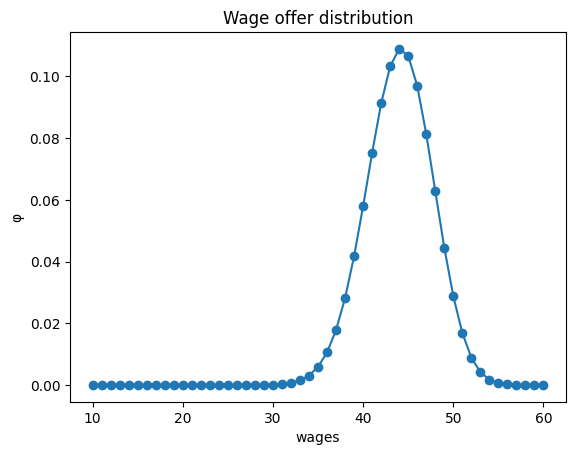

In [10]:
w_vals, phi, beta, c = params
fig, ax              = plt.subplots()
ax.plot(w_vals, phi, '-o')
ax.set_xlabel("wages")
ax.set_ylabel("φ")
ax.set_title("Wage offer distribution")
plt.show()

## Value Function Iteration

In order to apply the VFI process, we need to **prove that our Bellman equation satisfies the Blackwell's sufficiency conditions** to be a contraction mapping.

### **1. Monotonicity**
Let $V,M$ two different functions that satisfies that $V(w)≤M(w)
$ $∀w \in W$. If we name $w'$ the wealth and the labor income shock of the next period, resvectively, then...

\

$$V(w')≤M(w'),  ∀w'\in W$$

\

If we multiply both sides of the inequality by the wealth probability, then...

\

$$V(w')\phi (w')≤M(w')\phi (w'),  ∀w'\in W$$

\

The inequality also holds for the expected value of value functions, such that...

\

$$\sum_{w' \in W}V(w',y')\phi (y,y')≤\sum_{w' \in W}M(w',y')\phi (y,y')$$

$$β\sum_{w' \in W}V(w')\phi (w')≤β\sum_{w' \in W}M(w')\phi (w')$$

$$c+β\sum_{w' \in W}V(w')\phi (w')≤c+β\sum_{w' \in W}M(w')\phi (w')$$

\

Finally we add both sides the maximization of choosing either the stoping value or the continuation value, given a particular level of  current wage such that...

\

$$\max\left\{\frac{w}{1-\beta}, c + \beta \sum_{w' \in W} V(w') \phi(w')\right\} ≤\max\left\{\frac{w}{1-\beta}, c + \beta \sum_{w' \in W} M(w') \phi(w')\right\},  ∀w,y$$

\

Therefore, $T(V(w))≤T(M(w)), ∀w \in W$, which means that the transformation **satisifes monotonicity**.

### **2. Discounting**

Let's consider a value function $V$ and a positive constant $a$, such that

$$T(V(w)+a)=\max\left\{\frac{w}{1-\beta}, c + \beta \sum_{w' \in W} (V(w')+a) \phi(w')\right\}$$

\

$$T(V(w)+a)=\max\left\{\frac{w}{1-\beta}, c + \beta \sum_{w' \in W} (V(w')) \phi(w')+ \beta \sum_{w' \in W} a \phi(w')\right\}$$

\

$$T(V(w)+a)=\max\left\{\frac{w}{1-\beta}, c + \beta \sum_{w' \in W} (V(w')) \phi(w')+ a \beta \sum_{w' \in W} \phi(w')\right\}$$

\

Since it is fulfilled that $\sum_{w'\in W} \phi(w')=1$, such that

\

$$T(V(w)+a)=\max\left\{\frac{w}{1-\beta}, c + \beta \sum_{w' \in W} (V(w')) \phi(w')+ a \beta \right\}$$

\

In order to analize the relation between $T(V(w)+a)$ and $ T(V(w))+\beta a$, there are **four cases**:



1.   If $T(V(w)+a)=\frac{w}{1-\beta}$  and  $T(V(w))+\beta a = \frac{w}{1-\beta} +\beta a$, then $T(V(w)+a)≤ T(V(w))+\beta a$.
2.   If $T(V(w)+a)=\frac{w}{1-\beta}$ and $T(V(w))+\beta a = c + \beta \sum_{w' \in W} (V(w')) \phi(w') +\beta a$, then , since

\

$$\frac{w}{1-\beta} ≤ c + \beta \sum_{w' \in W} (V(w')) \phi(w')≤ c + \beta \sum_{w' \in W} (V(w')) \phi(w') +\beta a
$$

\

  we can conclude that $T(V(w)+a)≤ T(V(w))+\beta a$.

3.  If $T(V(w)+a)=c + \beta \sum_{w' \in W} (V(w')) \phi(w') +\beta a$ and $T(V(w))+\beta a = \frac{w}{1-\beta} +\beta a$. Note that  

\

$$
c + \beta \sum_{w' \in W} (V(w')) \phi(w') < \frac{w}{1-\beta}
$$

\

So

\

$$
c + \beta \sum_{w' \in W} (V(w')) \phi(w') + \beta a < \frac{w}{1-\beta} + \beta a
$$

Concluding that $T(V(w)+a)< T(V(w))+\beta a$

4.  If $T(V(w)+a)=c + \beta \sum_{w' \in W} (V(w')) \phi(w') +\beta a$ and $T(V(w))+\beta a = c + \beta \sum_{w' \in W} (V(w')) \phi(w') +\beta a$, then

\

$$T(V(w)+a) = T(V(w))+\beta a$$

\

Therefore, $T(V(w,y)+a)≤T(V(w,y))+aβ$, which means that the transformation **satisfies discounting**.



Now we can continue designing functions for the operators in the VFI

We will desingn a function for the **Bellman operator**:

\
$$
    (Tv)(w) = \max
    \left\{
        \frac{w}{1-\beta},
        c + \beta \sum_{w'} v(w') \phi(w')
    \right\}
$$

In [18]:
# Introduce the Bellman operator
def T(v, params):
    w_vals, phi, beta, c = params             # Unpacked parameters
    h                    = c + beta * v @ phi # Get the continuation value

    return np.maximum(w_vals / (1 - beta), h) # Returns a vector in which every element is the maximum between w_vals / (1 - β) and h

Now that that's clear, we need to make a function that computes the **$v$-greedy policy**, given $v$. Such that

\

$$
v_{\text{greedy}}= \text{argmax}\left\{\frac{w}{1-\beta},c+\beta \sum_{w'} v(w') \phi(w')\right\}
$$

In [19]:
def get_greedy(v, params):
    w_vals, phi, beta, c  = params
    stopping_vals         = w_vals / (1 - beta)
    continuation_val      = c + beta * v @ phi

    return np.where(stopping_vals >= continuation_val, 1, 0) # The np.where () function creates an array containing 1 in the wage positions for which the inequality holds,
                                                             # and 0 otherwise

## Value Function Iteration Procedure

We define a function for value function iteration as a function that would return the value function and the greedy function on the fixed point

In [20]:
def vfi(params):
    v_0 = np.zeros_like(params.w_vals)                                                                           # Set an initial guess for the value function
    v   = successive_approx(lambda v: T(v, params), v_0, lambda x, x_new: supremum_norm(x, x_new), verbose=True) # The lambda function is used to put one function as a parameter to another.
    σ   = get_greedy(v, params)                                                                                  # Get the policy function
    return v, σ

Now let's call it using the preset parameters.

In [21]:
params    = create_job_search_model()
v_star, σ = vfi(params)

Completed iteration 25 with error 5.504375849341159e-06.
Terminated successfully in 29 iterations.


It is very interesting to ask ourselves about what happens in the context of **a worker who does not receive compensation for being unemployed** $c$. Therefore we will solve the same exercise, but for $c=0$.

In [22]:
paramss     = create_job_search_model(c=0)
v_starr, σs = vfi(paramss)

Terminated successfully in 23 iterations.


Now, let's plot the different optimal value functions for both parameters.

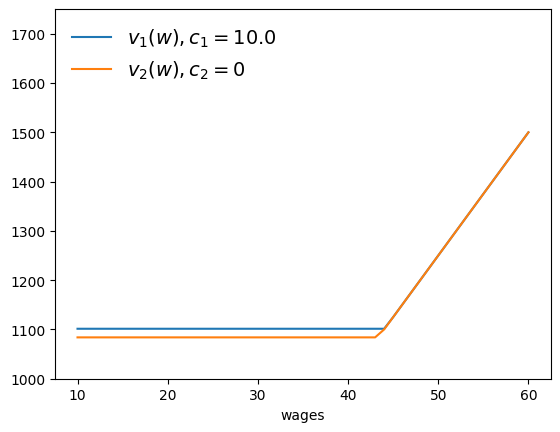

In [23]:
fig, ax = plt.subplots()
ax.plot(w_vals, v_star)
ax.plot(w_vals, v_starr)
ax.legend([f"$v_1(w), c_1= {params.c}$", f"$v_2(w), c_2= {paramss.c}$"], loc="upper left", frameon=False, fontsize=14)
ax.set_xlabel("wages")
ax.set_ylim(1000, 1750)
plt.show()

In the graph above we can see that the value function with a higher unemployment compensation is greater than the value function of an agent who does not have unemployment compensation. This  means that **workers who do not receive an unemployment insurance also receive a lower EPV**.

Also here's the **optimal policy for both parameters**.

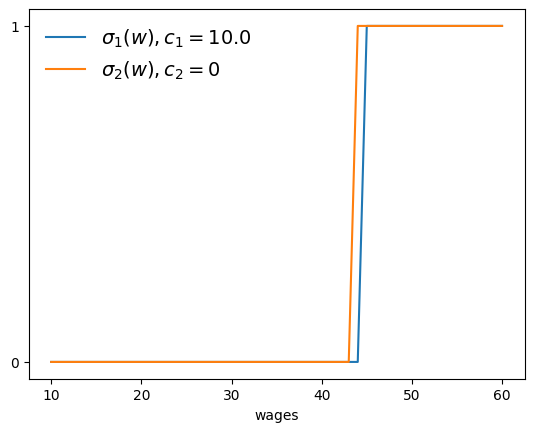

In [27]:
fig, ax = plt.subplots()
w_vals, ϕ, β, c = params
ax.plot(w_vals, σ)
ax.plot(w_vals, σs)
ax.legend([f"$σ_1(w), c_1= {params.c}$", f"$σ_2(w), c_2= {paramss.c}$"], loc="upper left", frameon=False, fontsize=14)
ax.set_xlabel("wages")
ax.set_yticks((0, 1))
plt.show()

Where $1$ means that the workers accept the job offer and $0$ means he reject.

In this graph we can see that an agent will accept a lower salary for the rest of his life if he does not receive an unemployment insurance, unlike a worker who does receive unemployment insurance.

This simple difference can have big consequences on a **worker standard of living**.

## Computing the Continuation Value Directly
Recall that the fixed point of

$$g(h) = c + \beta \sum_{w'} \max\{w'/(1-\beta), h\} \phi(w')$$

is the continuation value.



We will plot the fixed point $h^*$ of $g$ as a function of $\beta$.

First we have to make the **grid for the different values ​​of beta**.

In [28]:
betas = np.linspace(0.9, 0.99, 20)

Here's the function $g$. If we evaluate the $h^{*}$ inside it we will obtain the function at the fixed point.

In [29]:
def g(h, params):
    w_vals, phi, beta, c = params
    return c + beta * np.maximum(w_vals / (1 - beta), h) @ phi

Here's a function to compute its fixed point via successive approximation.

In [30]:
def compute_hstar(params, h_init=0.0):
    h_star = successive_approx(lambda h: g(h, params), h_init, lambda x, x_new: supremum_norm(x, x_new), verbose=True)
    return h_star

Now, we can compute the fixed point for each $\beta$ so that we can find the value function.

In [31]:
# With this code we will fill the h_vals tuple with the values ​​of h at the fixed point.
h_vals = np.empty_like(betas)
for i, beta in enumerate(betas):
    params    = create_job_search_model(beta = beta)
    h         = compute_hstar(params)
    h_vals[i] = h

Terminated successfully in 11 iterations.
Terminated successfully in 13 iterations.
Terminated successfully in 14 iterations.
Terminated successfully in 14 iterations.
Terminated successfully in 14 iterations.
Terminated successfully in 16 iterations.
Terminated successfully in 17 iterations.
Terminated successfully in 17 iterations.
Terminated successfully in 17 iterations.
Terminated successfully in 18 iterations.
Terminated successfully in 22 iterations.
Terminated successfully in 22 iterations.
Terminated successfully in 23 iterations.
Completed iteration 25 with error 4.259231445757905e-06.
Terminated successfully in 29 iterations.
Completed iteration 25 with error 7.837626071705017e-06.
Terminated successfully in 30 iterations.
Completed iteration 25 with error 1.2745523690682603e-05.
Terminated successfully in 31 iterations.
Completed iteration 25 with error 0.0006563466890838754.
Terminated successfully in 41 iterations.
Completed iteration 25 with error 0.0012758480734191835.


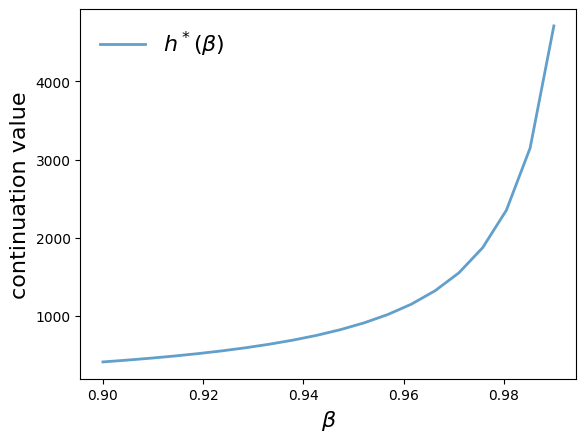

In [32]:
fs=16
fig, ax = plt.subplots()
ax.plot(betas, h_vals, lw=2.0, alpha=0.7, label="$h^*(\\beta)$")
ax.legend(frameon=False, fontsize=fs)
ax.set_xlabel("$\\beta$", fontsize=fs)
ax.set_ylabel("continuation value", fontsize=fs)
plt.show()

We can also plot the **reservation wage values**:

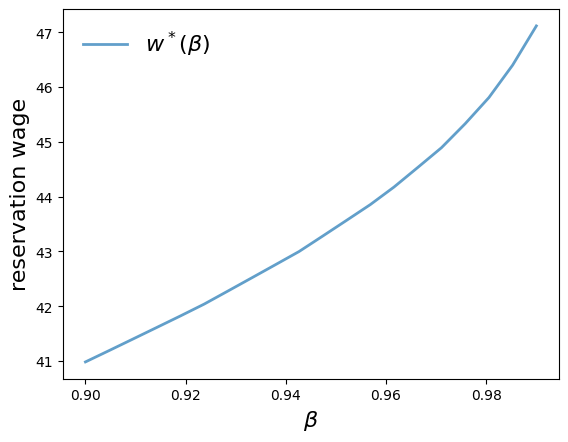

In [33]:
w_star_vals = (1 - betas) * h_vals
fig, ax = plt.subplots()
ax.plot(betas, w_star_vals, lw=2.0, alpha=0.7, label="$w^*(\\beta)$")
ax.legend(frameon=False, fontsize=fs)
ax.set_xlabel("$\\beta$", fontsize=fs)
ax.set_ylabel("reservation wage", fontsize=fs)
plt.show()

As the agent gets more patient, he prefers to wait for a better offer.  Hence the reservation wage goes up in $\beta$.
